<a href="https://colab.research.google.com/github/hemadamostafa/eye-disease-ai-detector/blob/main/EyE_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opendatasets --upgrade

# Import the data from kaggle to colab

In [3]:
import opendatasets as od

# URL of the Kaggle dataset
dataset_url = "https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification"

# This will download and unzip the dataset into the current working directory
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: choosen1
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification


100%|██████████| 736M/736M [00:06<00:00, 113MB/s]


# Check data and it's labels

In [4]:
import os

DATA_DIR = "eye-diseases-classification/dataset"  # path inside the unzipped folder
print("Using data from:", DATA_DIR)
print("Folders:", os.listdir(DATA_DIR))


Using data from: eye-diseases-classification/dataset
Folders: ['diabetic_retinopathy', 'normal', 'glaucoma', 'cataract']


# Check that we're using the GPU n't just the CPU

In [5]:
import torch

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Currently using: {device}")


Currently using: cuda


# Warm up with the data to:-
- Resize the images
- some augmentationn
- normalize these data (Extremly important)
- Splet them

In [18]:
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),            # Resize images
    transforms.RandomHorizontalFlip(p=0.5),   # Data augmentation
    transforms.ToTensor(),                     # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Create the dataset
dataset = ImageFolder(root=DATA_DIR, transform=transform)

# 80% for training, 20% for testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_data, test_data = random_split(dataset, [train_size, test_size])

print(f"Training images: {len(train_data)}")
print(f"Testing images:  {len(test_data)}")

Training images: 3373
Testing images:  844


# Loader Preparation and choosing the Batch size

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Training DataLoader (shuffled)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# Testing DataLoader (not shuffled)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Batches in train_dataloader: {len(train_dataloader)}")


Batches in train_dataloader: 106


# Have a look on the data how is the diseases

Image batch shape: torch.Size([32, 3, 128, 128])
Labels shape: torch.Size([32])


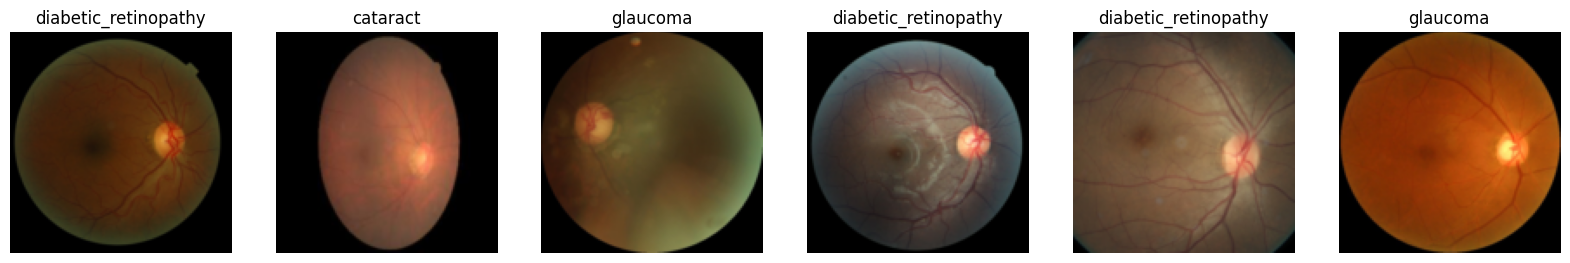

In [10]:
import matplotlib.pyplot as plt
import torch

# Grab one batch of images
images, labels = next(iter(train_dataloader))

print("Image batch shape:", images.shape)
print("Labels shape:", labels.shape)

# Plot the first 6 images
fig, axes = plt.subplots(1, 6, figsize=(20, 5))
for i in range(6):
    ax = axes[i]
    img = images[i].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
    ax.imshow(img)
    ax.set_title(dataset.classes[labels[i]])
    ax.axis("off")

plt.show()


# The Structure of the CNN:-
- Convolutions
- The Activation functions (ReLU)
- Poolings
- Flatten


In [19]:
import torch
from torch import nn

class EyeDiseaseModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        # BLOCK 1: Finding simple shapes (edges, lines)
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # compress image by half
        )

        # BLOCK 2: Finding complex shapes (textures, circles)
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # compress again (1/4 of original)
        )

        # CLASSIFIER: Flatten and fully connected
        # Original comment was for 224x224 images. For 128x128 images after two 2x2 max pools, it's 32x32.
        # 128 pixels / 2 (pool1) / 2 (pool2) = 32 pixels left
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*32*32, out_features=output_shape) # Corrected in_features
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

# Instantiate the model
model = EyeDiseaseModel(input_shape=3, hidden_units=32, output_shape=4).to(device)

from torchvision import models
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 4)
model = model.to(device)

print(model)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
import torch.optim as optim
import torch.nn as nn

# Loss function: CrossEntropyLoss for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Optimizer: Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Setup complete. Model is ready to train!")


Setup complete. Model is ready to train!


# As we prepared the model we need to prepare how we can judge or evaluate this model

In [21]:
import time
from tqdm.auto import tqdm

def train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, epochs=15):

    # Track metrics
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    start_time = time.time()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}\n-------------------------------")

        # --- TRAINING PHASE ---
        model.train()
        train_loss, train_acc = 0, 0

        for batch, (X, y) in enumerate(tqdm(train_loader, desc="Training")):
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Compute loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            # Backward pass & optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute batch accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        # Average stats per batch
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        # --- TESTING PHASE ---
        model.eval()
        test_loss, test_acc = 0, 0

        with torch.inference_mode():
            for X, y in tqdm(test_loader, desc="Testing"):
                X, y = X.to(device), y.to(device)

                test_pred = model(X)

                test_loss += loss_fn(test_pred, y).item()
                test_acc += (test_pred.argmax(1) == y).sum().item() / len(y)

        test_loss /= len(test_loader)
        test_acc /= len(test_loader)

        # Print stats
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
        print(f"Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.2%}")

        # Store results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    end_time = time.time()
    print(f"\nTotal Training Time: {end_time - start_time:.2f} seconds")
    return results

# Now Let's train the model

In [22]:
# Run training
model_results = train_and_evaluate(
    model,
    train_dataloader,
    test_dataloader,
    loss_fn,
    optimizer,
    epochs=15  # You can reduce to 5 for testing
)


Epoch 1/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.5558 | Train Acc: 78.51%
Test  Loss: 0.6115 | Test  Acc: 73.73%

Epoch 2/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.3490 | Train Acc: 87.16%
Test  Loss: 0.2699 | Test  Acc: 90.39%

Epoch 3/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.2619 | Train Acc: 90.61%
Test  Loss: 0.2961 | Test  Acc: 89.16%

Epoch 4/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.2501 | Train Acc: 90.95%
Test  Loss: 1.3693 | Test  Acc: 64.74%

Epoch 5/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1956 | Train Acc: 92.50%
Test  Loss: 0.3002 | Test  Acc: 88.58%

Epoch 6/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1949 | Train Acc: 93.15%
Test  Loss: 0.3499 | Test  Acc: 87.19%

Epoch 7/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1791 | Train Acc: 93.40%
Test  Loss: 0.2826 | Test  Acc: 89.16%

Epoch 8/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1351 | Train Acc: 95.61%
Test  Loss: 0.3679 | Test  Acc: 87.89%

Epoch 9/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1010 | Train Acc: 96.49%
Test  Loss: 0.3782 | Test  Acc: 88.23%

Epoch 10/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0846 | Train Acc: 96.95%
Test  Loss: 0.4806 | Test  Acc: 87.92%

Epoch 11/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0892 | Train Acc: 96.99%
Test  Loss: 0.3573 | Test  Acc: 88.81%

Epoch 12/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0662 | Train Acc: 97.75%
Test  Loss: 0.2789 | Test  Acc: 91.94%

Epoch 13/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0975 | Train Acc: 96.14%
Test  Loss: 0.4372 | Test  Acc: 86.73%

Epoch 14/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0635 | Train Acc: 98.02%
Test  Loss: 0.2958 | Test  Acc: 92.05%

Epoch 15/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0470 | Train Acc: 98.66%
Test  Loss: 0.4571 | Test  Acc: 89.31%

Total Training Time: 622.03 seconds


# Nice accurecy now let's save this model on google Drive

In [23]:
from pathlib import Path
from google.colab import drive
import torch

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Create a folder for models in your Drive (optional)
MODEL_DIR = Path("/content/drive/MyDrive/eye_disease_models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# 3. Define model filename
MODEL_NAME = "custom_eye_cnn.pth"
MODEL_PATH = MODEL_DIR / MODEL_NAME

# 4. Save the model state
torch.save(model.state_dict(), MODEL_PATH)

print(f"✅ Model saved to: {MODEL_PATH}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved to: /content/drive/MyDrive/eye_disease_models/custom_eye_cnn.pth


# Back Story (Concolusion):-
## It wasn't simple as you read to reach this accurecy. actully the last version of the model got stuck to 27% accurecy along 15 epoch

## so I fine tuned the model alittle bit:-
- I changed the resize from (128, 128) to (224, 224)
- we have only almost 800 pictures which is too small we need to make some augmantation for this data so I used "transforms.RandomHorizontalFlip(p=0.5)" to flib some of the data
- Normalization which is extremly important too I didn't do it before.
- Increased the hidden_units to 32 to give the model the ability to focus on more details basicly make the model get closer to overfitting. because the model was underfit
- Finally used "resnet18"

- Summary:-
High-res images
↓
Augmentation
↓
Normalization
↓
Pretrained Vision Brain
↓
Fast + Accurate + Stable